In [1]:
import cPickle as pickle
import os

from sigvisa import Sigvisa



In [2]:
s = Sigvisa()

mcmc_run = 1750
step = 919
mcmc_log_dir = os.path.join(s.homedir, "logs", "mcmc")
mcmc_run_dir = os.path.join(mcmc_log_dir, "%05d" % mcmc_run)
sgfile = os.path.join(mcmc_run_dir, "step_%06d/pickle.sg" % step)
with open(sgfile, 'rb') as f:
    sg = pickle.load(f)

In [3]:
print sg.station_waves.keys()

['MK31', 'CM16', 'BVA0', 'WR1', 'AKTO', 'ZAA0', 'FITZ', 'CTA', 'INK', 'SONA0', 'AS12', 'KURBB']


# Model evidence for GP wiggle predictions

In [4]:
sta="MK31"
chan="BHZ"
band="freq_0.8_4.5"
phase="P"

eids = sg.evnodes.keys()

eid_wiggle_posteriors = dict()

wiggle_gpmodels = dict([(k, v) for (k, v) in sg._joint_gpmodels[sta].items() if k.startswith("db")])

holdout_evidence = dict()

for eid in eids:
    try:
        holdout_evidence[eid] = np.sum([jgp.holdout_evidence(eid) for jgp in wiggle_gpmodels.values()])
    except KeyError:
        continue

"""
n = len(eids)
pairwise_evidence = np.zeros((n,n))
for i, eid1 in enumerate(eids):
    for j, eid2 in enumerate(eids):
        pairwise_evidence[i,j] = 0
        pairwise_evidence[j,i] = 0
        for jgp in wiggle_gpmodels.values():
            p1, p2 =  jgp.pairwise_evidence(eid1, eid2)
            # evidence for row|col
            pairwise_evidence[i,j] += p1 # evidence for eid1|eid2
            pairwise_evidence[j,i] += p2 # evidence for eid2|eid1
"""

'\nn = len(eids)\npairwise_evidence = np.zeros((n,n))\nfor i, eid1 in enumerate(eids):\n    for j, eid2 in enumerate(eids):\n        pairwise_evidence[i,j] = 0\n        pairwise_evidence[j,i] = 0\n        for jgp in wiggle_gpmodels.values():\n            p1, p2 =  jgp.pairwise_evidence(eid1, eid2)\n            # evidence for row|col\n            pairwise_evidence[i,j] += p1 # evidence for eid1|eid2\n            pairwise_evidence[j,i] += p2 # evidence for eid2|eid1\n'

In [5]:
print holdout_evidence

{1: 15.743486524571876, 2: 15.411244025767456, 3: 10.849557795406881, 4: 0.029848857149183505, 5: 8.286175047704365, 6: 0.0, 7: 7.8544755959545389, 8: 14.343861886465906, 9: 16.908044031650171, 10: 0.77441471125510186, 11: 1.4576380059025551, 12: 3.2492810158469316, 13: -0.088006181774019865, 14: 10.07705688115432, 15: 5.9384208167001162, 16: 1.9560974518217888, 17: 7.0775786804324996, 18: 0.55146782617698931, 19: 2.2446963704802751, 20: 8.0883366355182496, 21: 15.074680478341753, 22: 2.5357974516754371, 23: 0.66638092090333223, 24: 7.4601280991522909, 25: 13.047908356980063, 26: -2.8736141652127829, 27: 9.1644351657215619, 28: 4.9274869532162402, 29: 3.0862735571959945, 30: 10.639455593673414, 31: 8.1579656589520901, 32: 1.0572749593197306, 33: 13.210623152307484}


In [6]:
imshow(pairwise_evidence, interpolation=None)

NameError: name 'pairwise_evidence' is not defined

In [7]:
# NEXT TODO: actually realize the inferred wiggles and correlate them
# (NOT cross-correlation since we expect to have actually found alignments)
# (could also try realizing the actual wiggled templates)

# Correlations of inferred wiggles

orig [13, 13]
appending 34 from 20
appending 62 from 34
padded [13, 13, 20, 34]
constructed wavelet basis with 26 params for signal of length 62


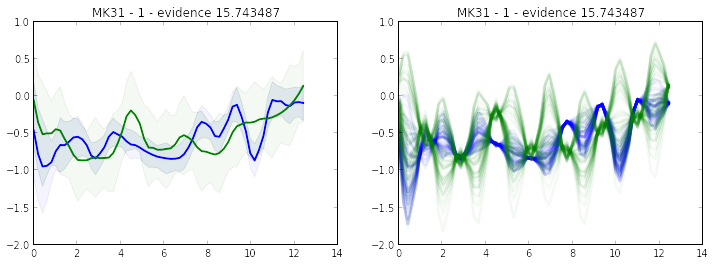

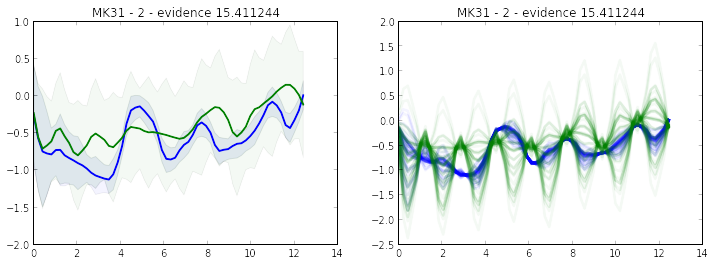

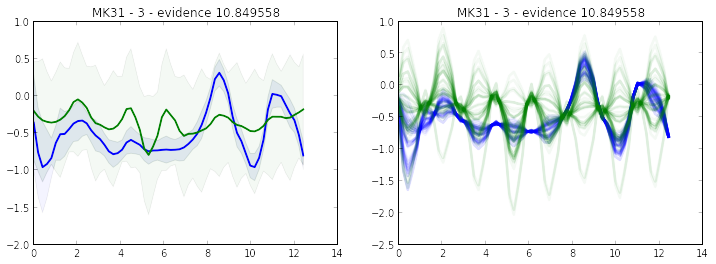

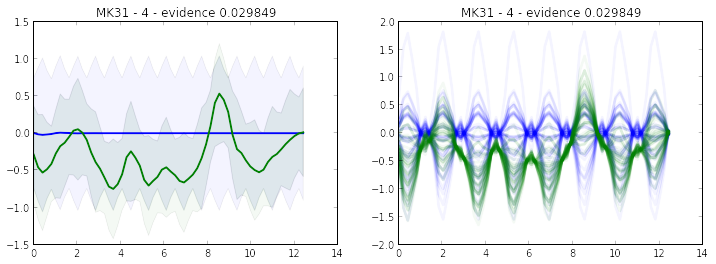

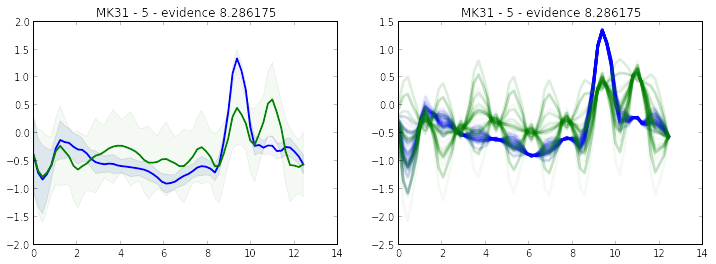

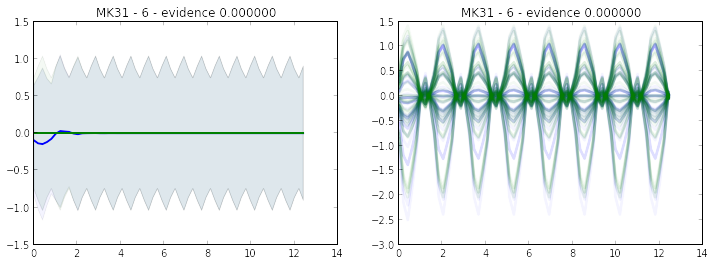

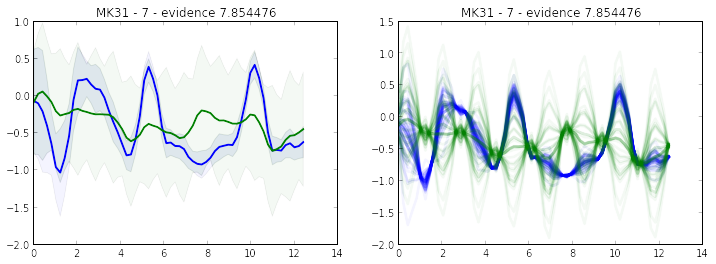

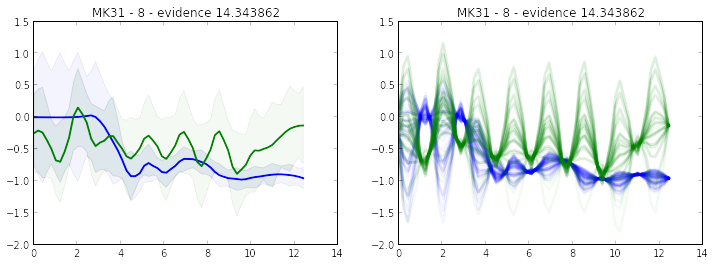

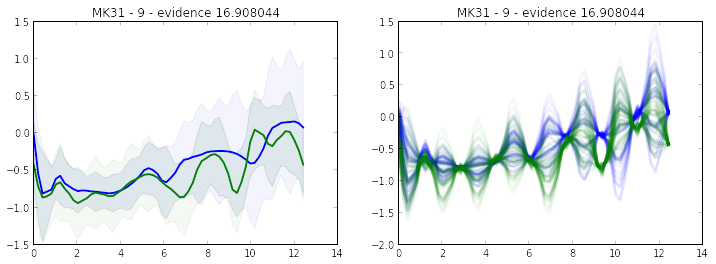

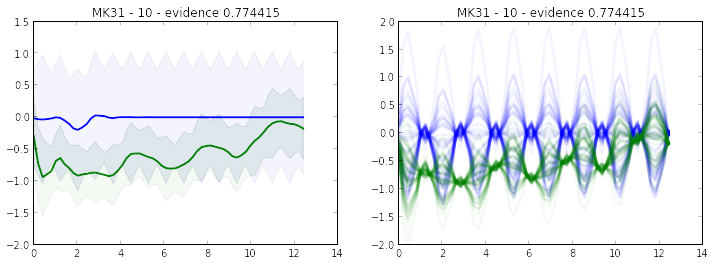

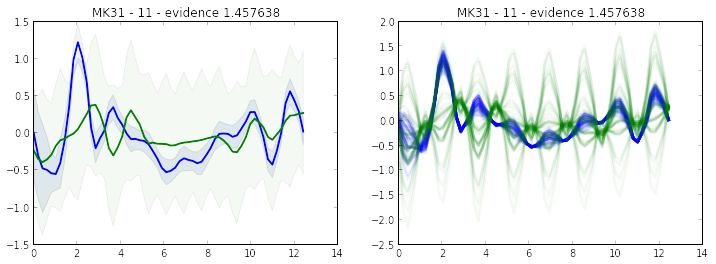

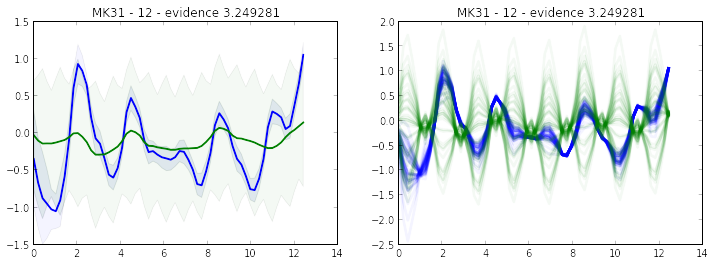

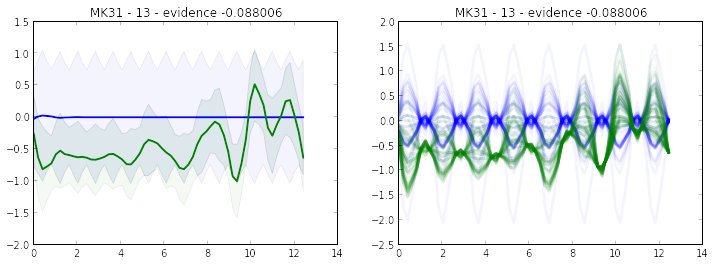

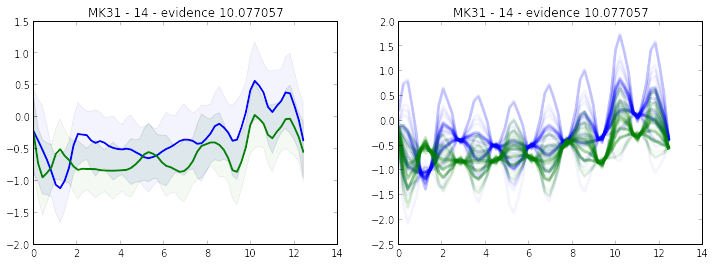

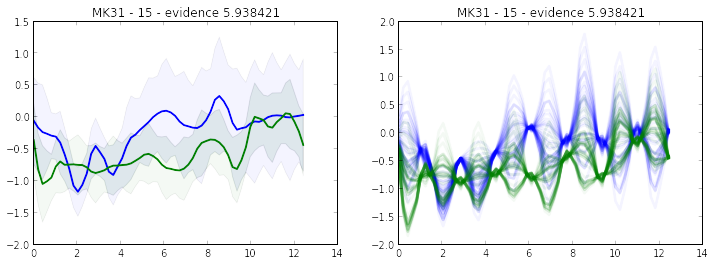

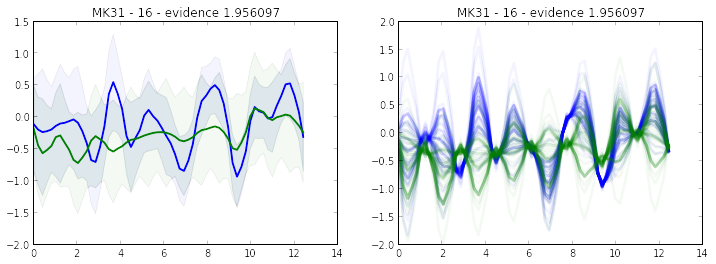

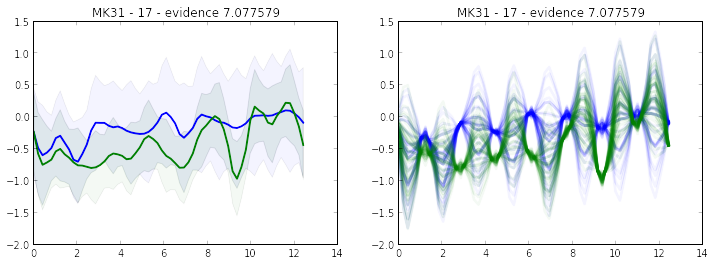

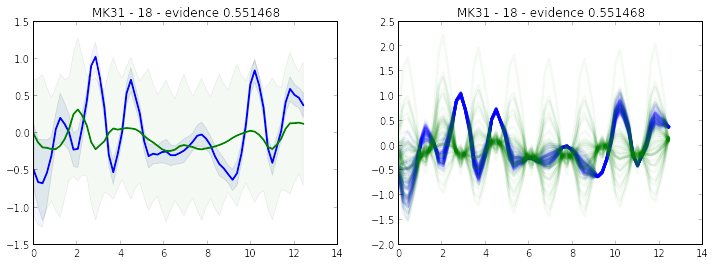

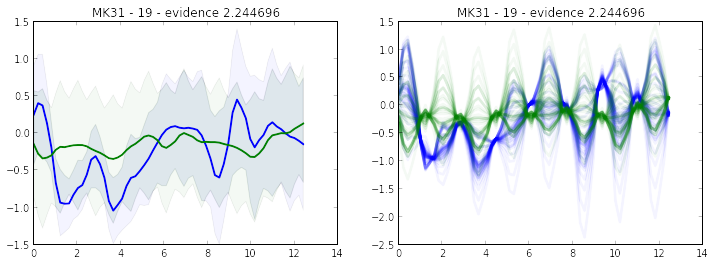

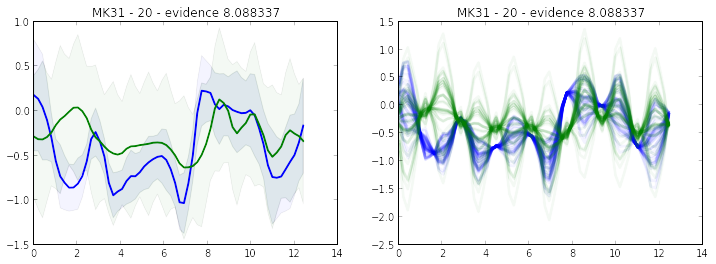

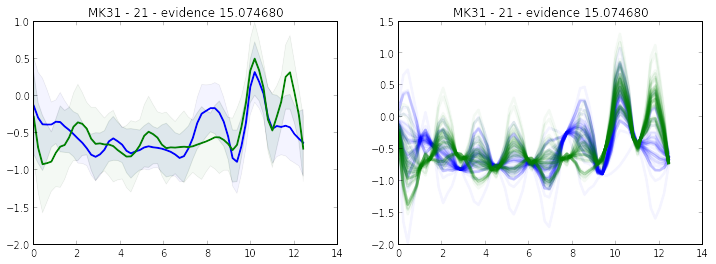

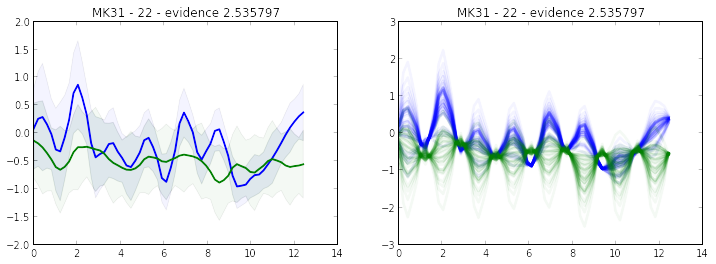

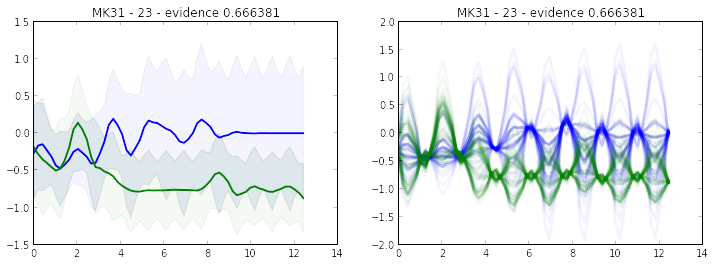

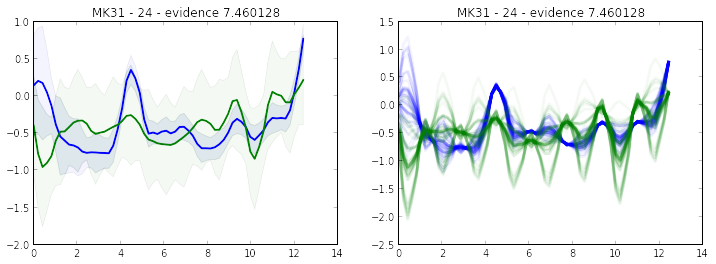

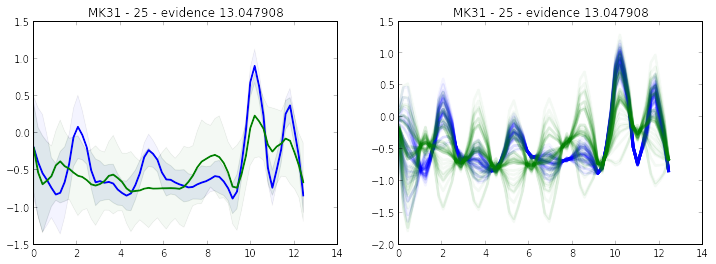

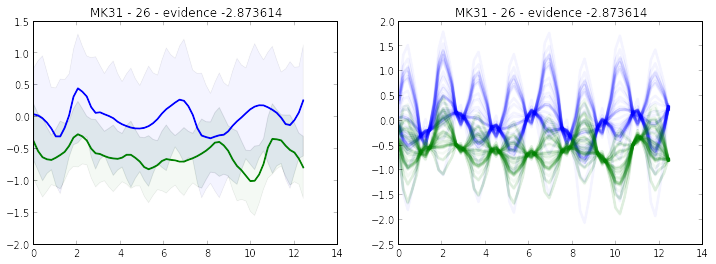

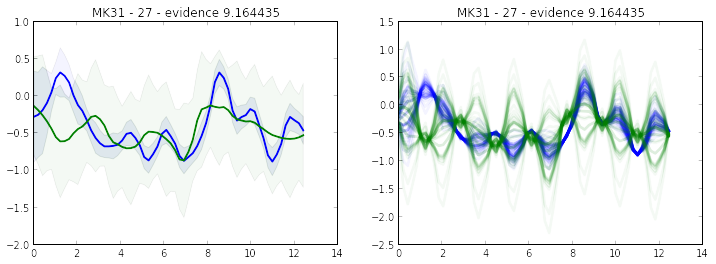

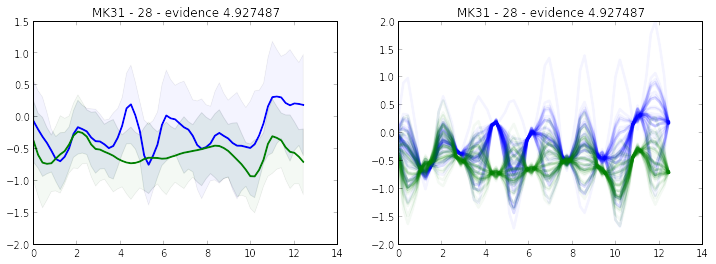

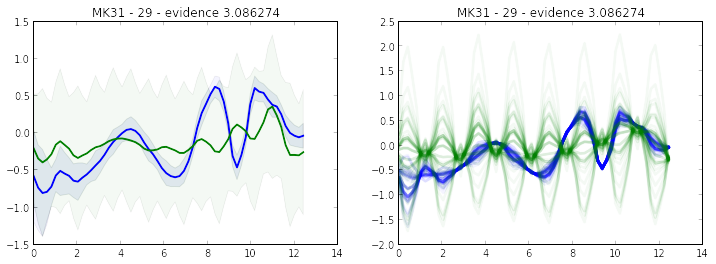

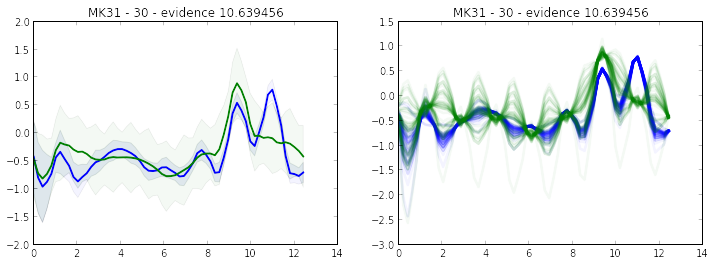

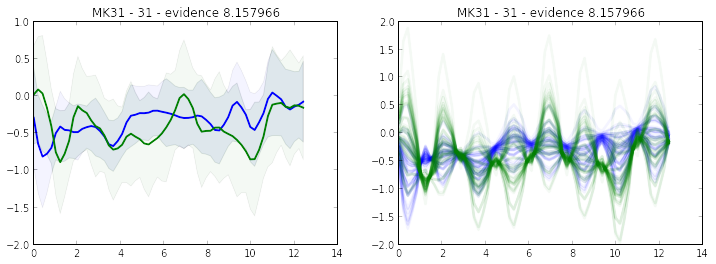

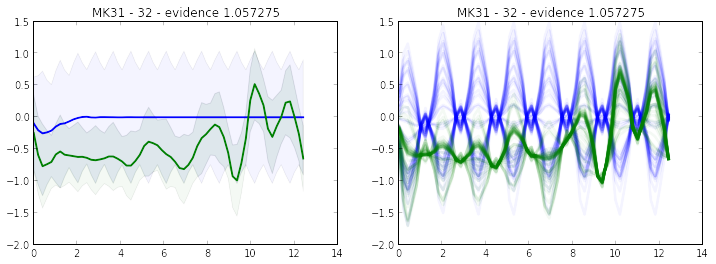

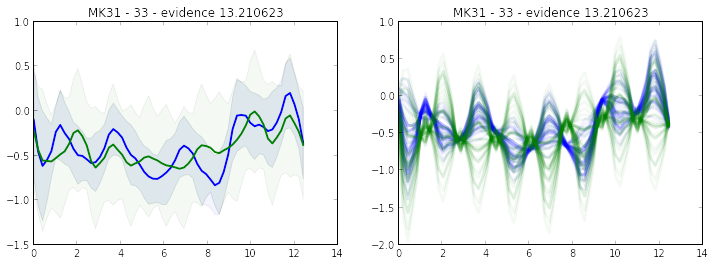

In [8]:
from sigvisa.models.wiggles.wavelets import construct_wavelet_basis
basis = construct_wavelet_basis(5.0, sg.wiggle_family)


def plot_wavelet_dist_samples(ax, srate, basis, wmeans, wvars, c="blue"):
    wmeans = np.asarray(wmeans).flatten()
    wvars = np.asarray(wvars).flatten()
    
    n = basis.shape[1]
    x = np.linspace(0, n/float(srate), n)
    for n in range(30):
        ws = np.random.randn()*np.sqrt(wvars)+wmeans
        w = np.dot(basis.T, ws)
        ax.plot(x, w, c=c, linestyle="-", alpha=0.2, lw=3)
        
        
def plot_wavelet_dist(ax, srate, basis, wmeans, wvars, c="blue"):
    wmeans = np.asarray(wmeans).flatten()
    wvars = np.asarray(wvars).flatten()
    
    w = np.dot(basis.T, wmeans)
    wv = np.diag(np.dot(basis.T, np.dot(np.diag(wvars), basis)))
    n = basis.shape[1]
    x = np.linspace(0, n/float(srate), n)
    ax.plot(x, w, c=c, linestyle="-", lw=2)
    ax.fill_between(x, w+2*np.sqrt(wv), w-2*np.sqrt(wv), facecolor=c, alpha=0.2)



for wn in sg.station_waves[sta]:
    wn.pass_jointgp_messages()
    ell, prior_means, prior_vars, posterior_means, posterior_vars = wn._coef_message_cache
    
    for i, (eid, phase, _, _, _, ctype) in enumerate(wn.tssm_components):
        if ctype != "wavelet": continue
        cond_means, cond_vars = zip(*[jgp.posterior(eid) for jgp in wn.wavelet_param_models[phase]])

        f = figure(figsize=(12, 4))
        ax = f.add_subplot(121)
        plot_wavelet_dist(ax, wn.srate, basis, posterior_means, posterior_vars, c="blue")
        plot_wavelet_dist(ax, wn.srate, basis, cond_means, cond_vars, c="green")
        ax.set_title("%s - %d - evidence %f" % (sta, eid, holdout_evidence[eid]))
        ax = f.add_subplot(122)
        plot_wavelet_dist_samples(ax, wn.srate, basis, posterior_means, posterior_vars, c="blue")
        plot_wavelet_dist_samples(ax, wn.srate, basis, cond_means, cond_vars, c="green")
        ax.set_title("%s - %d - evidence %f" % (sta, eid, holdout_evidence[eid]))


26

In [32]:
def flatten_cov(C):
    n = C.shape[0]
    flat = np.empty(((n*(n+1))/2))

    L = np.linalg.cholesky(C)
    print L
    
    idx = 0
    for i in range(n):
        col = L[i:, i]
        flat[idx:idx+len(col)] = col
        idx += len(col)
    return flat

def unflatten_cov(flat):
    n = int((np.sqrt(1+8*len(flat)) - 1)/2)
    L = np.zeros((n,n))

    idx = 0
    for i in range(n):
        L[i:, i] = flat[idx:idx+(n-i)]
        idx += n-i
    print L
        
    C = np.dot(L, L.T)
    return C

In [33]:

L = np.random.randn(3, 3)
C = np.dot(L, L.T)
f = flatten_cov(C)
C2 = unflatten_cov(f)
print C-C2

[[ 1.73424967  0.          0.        ]
 [-0.12098342  1.6883074   0.        ]
 [-1.42512108 -1.05866249  0.99998315]]
[[ 1.73424967  0.          0.        ]
 [-0.12098342  1.6883074   0.        ]
 [-1.42512108 -1.05866249  0.99998315]]
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
